In [17]:
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal, Laplace
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from sklearn.preprocessing import StandardScaler
from jax import vmap
import pandas as pd
import json
import pickle
import scipy

In [112]:
#observed data
filename = "./previous/observed_stats.csv"
x_o = pd.read_csv(filename)
#simulated data
filename2 = "./previous/summary_stats_r3.csv"
x = pd.read_csv(filename2)
#params for simulations
filename3 = "./previous/thetas_r3.csv"
theta = jnp.array(np.genfromtxt(filename3, delimiter=',', dtype=float))

In [115]:
to_drop = ["y1_domestic",
           #"tajimas_d_eu",
           "y1_scot",
           "y1_captive",
           "y1_eu",
           "y1_lyb",
           'pc1_dist_eu_lyb',
           'pc1_dist_captive_lyb',
           'pc1_median_lyb',
           'y3_scot_captive_eu',
           'y3_domestic_eu_lyb',
           'y3_domestic_captive_lyb',
           'y3_domestic_scot_lyb',
           'y3_domestic_scot_eu',
           'y3_domestic_scot_captive',
           'y2_domestic_lyb',
           'f4_domestic_scot_eu_lyb',
           'f4_domestic_captive_eu_lyb',
           'f4_domestic_scot_captive_lyb',
           'f2_eu_lyb',
           'divergence_eu_lyb',
           'divergence_captive_lyb',
           'divergence_scot_lyb',
           'divergence_domestic_lyb',
           'pc1_median_domestic',
           'pc1_median_scot',
           'pc1_median_captive',
           'pc1_median_eu',
           'pc1_iqr_domestic',
           'pc1_iqr_eu',
           'pc1_iqr_lyb',
           'pc2_iqr_domestic',
           'pc2_iqr_lyb'
          ]

In [116]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(9915, 102)

In [5]:
#normalise data
x_scaler = StandardScaler()
print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 97)
x_t shape (10000, 97)
x_o_t shape (1, 97)


In [6]:
theta = theta[1:10001]
log_theta = jnp.log(theta)
theta_scaler = StandardScaler()
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (10000, 16)


In [7]:
# save scaler models
with open('./previous/x_scaler_jax.pkl','wb') as f:
    pickle.dump(x_scaler, f)
    
with open('./previous/theta_scaler_jax.pkl','wb') as f:
    pickle.dump(theta_scaler, f)

In [117]:
with open('./previous/x_scaler_jax.pkl','rb') as f:
    x_scaler = pickle.load(f)

print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:9914])
x_o_t = np.float32(combined_x_t[9914])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (9915, 102)
x_t shape (9914, 102)
x_o_t shape (1, 102)


C:\Users\harrg\AppData\Local\anaconda3\envs\wildcats\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [118]:
with open('./previous/theta_scaler_jax.pkl','rb') as f:
    theta_scaler = pickle.load(f)

theta = theta[1:9915]
log_theta = jnp.log(theta)
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (9914, 16)


C:\Users\harrg\AppData\Local\anaconda3\envs\wildcats\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [119]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior
unbounded_prior = Normal(jnp.zeros(16))

In [120]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(16)),
    transformer=bij.Affine(),
    cond_dim=x_o_t.size,
)

In [121]:
#for sequential:
flow = eqx.tree_deserialise_leaves("./previous/posterior_r2.eqx", flow)

In [122]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-5),
    )

In [123]:
loss_fn = ContrastiveLoss(unbounded_prior, n_contrastive=10)

In [124]:
fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=theta_t,
    condition=x_t,
    max_epochs=1000,
    optimizer=optimizer
)

 11%|█         | 112/1000 [07:29<59:26,  4.02s/it, train=-24.159336, val=-23.341074 (Max patience reached)]


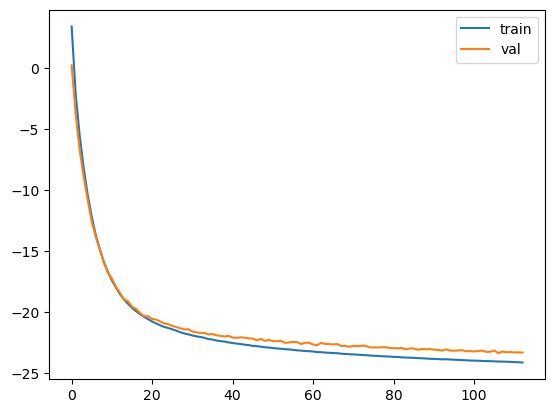

In [125]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()

In [30]:
# save proposal between rounds
model = fitted_flow

eqx.tree_serialise_leaves("./previous/posterior_r4.eqx", model)

In [138]:
# save sample parameters for next round
posterior = fitted_flow
samples = posterior.sample(subkey, (1000000,), condition=x_o_t)
print(np.shape(samples))
samples = np.reshape(samples, (1000000,16))

(1000000, 1, 16)


In [141]:
samples = samples[~np.isnan(samples).any(axis=1)]

In [142]:
len(samples)

999943

In [143]:
samples

Array([[ 0.33878416,  2.1184177 , -6.253356  , ...,  1.8297771 ,
        -2.4432154 , -1.6282008 ],
       [ 0.03290573,  2.713084  , -4.3321133 , ...,  2.566118  ,
        -3.2367904 , -1.6537509 ],
       [ 0.25393707,  2.656356  , -3.4700327 , ...,  2.1623971 ,
        -2.903641  , -1.4869953 ],
       ...,
       [-0.11124669,  2.2854805 , -9.196254  , ...,  2.1793127 ,
        -2.9391453 , -1.7426172 ],
       [ 0.19244756,  2.1686583 , -4.284598  , ...,  1.9787425 ,
        -2.5027492 , -1.3913974 ],
       [-0.09439966,  2.7494774 , -4.527868  , ...,  2.4825497 ,
        -3.175158  , -3.4238799 ]], dtype=float32)

In [137]:
def remove_infnan(array):
    '''
    This function will remove all samples with nan or inf in.
    '''
    #remove nan
    samples = array[~np.isnan(array).any(axis=1)]

    #remove inf / -inf

    samples = samples[~(array == inf).any(axis=1)]

    return samples

In [140]:
samples_2 = remove_infnan(samples)

NameError: name 'inf' is not defined

In [146]:
samples2 = theta_scaler.inverse_transform(samples)
theta_4 = np.exp(samples2)

C:\Users\harrg\AppData\Local\Temp\ipykernel_10072\2222953820.py:2: RuntimeWarning: overflow encountered in exp
  theta_4 = np.exp(samples2)


In [91]:
theta_5 = theta_5[~np.isnan(theta_5).any(axis=1)]

In [147]:
len(theta_4)

999943

In [148]:
theta_4

array([[2.23399429e+01, 3.08446344e+05, 6.08328857e+02, ...,
        1.12695031e+05, 3.21826210e-09, 1.03492424e-08],
       [1.87210388e+01, 3.79953094e+05, 1.02329126e+03, ...,
        1.49485562e+05, 2.59981348e-09, 1.02951203e-08],
       [2.12711983e+01, 3.72470500e+05, 1.29224573e+03, ...,
        1.28034938e+05, 2.84347768e-09, 1.06534515e-08],
       ...,
       [1.72249813e+01, 3.27053125e+05, 2.74266022e+02, ...,
        1.28868555e+05, 2.81645707e-09, 1.01091171e-08],
       [2.05287628e+01, 3.13927875e+05, 1.03653748e+03, ...,
        1.19323695e+05, 3.16714699e-09, 1.08644631e-08],
       [1.73934631e+01, 3.84832031e+05, 9.70479187e+02, ...,
        1.44768688e+05, 2.64326427e-09, 7.15984205e-09]], dtype=float32)

In [94]:
theta_5[2]

array([1.9352438e+01, 4.5077750e+05, 2.5844299e+02, 1.0760387e-02,
       2.2460482e-01, 3.2197639e-02, 1.7362091e+01, 2.9225084e+01,
       1.0207693e+04, 5.8721277e+02, 3.1628068e+06, 5.4988358e-15,
                 inf, 0.0000000e+00,           inf, 7.4957116e-09],
      dtype=float32)

In [149]:
np.shape(theta_4)
tr4 = pd.DataFrame(theta_4)
tr4.to_csv("./for_plots/tr4_jax_big_2.csv", index=False)

In [125]:
samples2 = []
samples2 = np.reshape(samples[0:10000], (10000,16))
samples2 = theta_scaler.inverse_transform(samples2)
np.shape(samples2)

(10000, 16)

In [127]:
window = np.reshape(samples[1120000:1130000], (10000,16))
window = theta_scaler.inverse_transform(window)
samples2 = np.append(samples2, window, axis=0)
np.shape(samples2)

(1000000, 16)

In [128]:
save1 = samples2

In [132]:
#parameter names for plots
names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

In [133]:
theta_3 = pd.read_csv("./previous/thetas_r3.csv")
theta_3 = theta_3.to_numpy(dtype=np.float32)
theta_2 = pd.read_csv("./previous/thetas_r2.csv")
theta_2 = theta_2.to_numpy(dtype=np.float32)
theta = pd.read_csv("./thetas_r1.csv")
np.shape(theta_2)

(10000, 16)

In [151]:
priors_dict ={
    "captive_time": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "div_time": scipy.stats.lognorm(s=1, loc=0, scale=50000),
    "div_time_dom": scipy.stats.lognorm(s=0.4, loc=1000, scale=2500),
    "div_time_scot": scipy.stats.lognorm(s=0.2, loc=0, scale=3000),
    "mig_rate_captive": scipy.stats.lognorm(s=0.5, loc=0, scale=0.08),
    "mig_rate_scot": scipy.stats.lognorm(s=0.5, loc=0, scale=0.08),
    "mig_length_scot": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "pop_size_captive": scipy.stats.lognorm(s=0.5, loc=10, scale=100),
    "pop_size_domestic_1": scipy.stats.lognorm(s=1, loc=0, scale=50000),
    "pop_size_lyb_1": scipy.stats.lognorm(s=1, loc=0, scale=20000),
    "pop_size_lyb_2": scipy.stats.lognorm(s=1, loc=0, scale=80000),
    "pop_size_scot_1": scipy.stats.lognorm(s=0.8, loc=0, scale=np.exp(8)),
    "pop_size_eu_1": scipy.stats.lognorm(s=1, loc=0, scale=10000),
    "pop_size_eu_2": scipy.stats.lognorm(s=1, loc=0, scale=40000),
    "mutation_rate": scipy.stats.lognorm(s=1, loc=0, scale=1e-8),
    "recombination_rate": scipy.stats.lognorm(s=0.5, loc=1e-8, scale=5.0e-9)
}

theta = []
for key, prior in priors_dict.items():
    theta.append(prior.rvs(10000))
theta = np.concatenate(theta, axis=0)
print(np.shape(theta))
theta = np.reshape(theta, (16,10000))
print(np.shape(theta))

(160000,)
(16, 10000)


In [152]:
params = {
    "captive_time": {"bins" : np.arange(0, 100, 1), "lims" : [0, 100]},
    "div_time": {"bins" : np.arange(0, 400000, 3000), "lims" : [0, 400000]},
    "div_time_dom": {"bins" : np.arange(500, 11000, 100), "lims" : [500, 11000]},
    "div_time_scot": {"bins" : np.arange(1000, 7000, 50), "lims" : [1000, 7000]},
    "mig_rate_captive": {"bins" : np.arange(0, 0.4, 0.005), "lims" : [0, 0.4]},
    "mig_rate_scot": {"bins" : np.arange(0, 0.3, 0.004), "lims" : [0, 0.3]},
    "mig_length_scot": {"bins" : np.arange(0, 80, 1), "lims" : [0, 80]},
    "pop_size_captive": {"bins" : np.arange(0, 500, 5), "lims" : [0, 500]},
    "pop_size_domestic_1": {"bins" : np.arange(0, 500000, 4000), "lims" : [0, 500000]},
    "pop_size_lyb_1": {"bins" : np.arange(0, 100000, 800), "lims" : [0, 100000]},
    "pop_size_lyb_2": {"bins" : np.arange(0, 750000, 5000), "lims" : [0, 750000]},
    "pop_size_scot_1": {"bins" : np.arange(0, 30000, 200), "lims" : [0, 30000]},
    "pop_size_eu_1": {"bins" : np.arange(0, 150000, 2000), "lims" : [0, 150000]},
    "pop_size_eu_2": {"bins" : np.arange(0, 250000, 2500), "lims" : [0, 250000]},
    "mutation_rate": {"bins" : np.arange(0, 0.6e-7, 0.6e-9), "lims" : [0, 0.6e-7]},
    "recombination_rate": {"bins" : np.arange(0.5e-8, 3.5e-8, 3e-10), "lims" : [0.5e-8, 3.5e-8]}
         }

names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

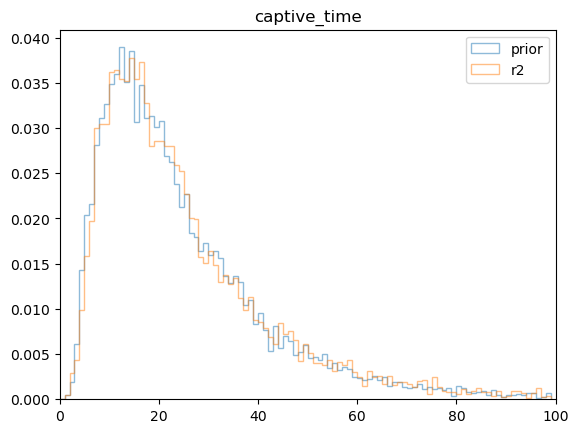

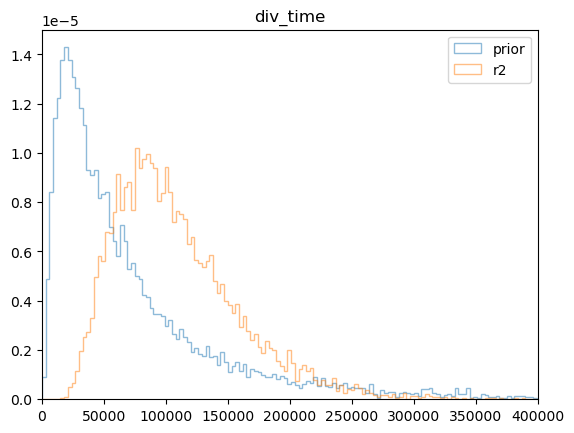

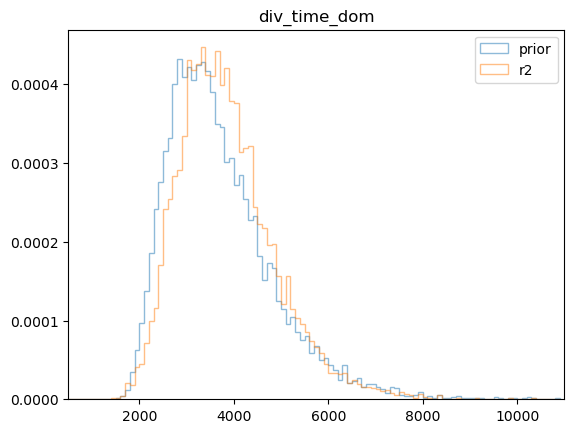

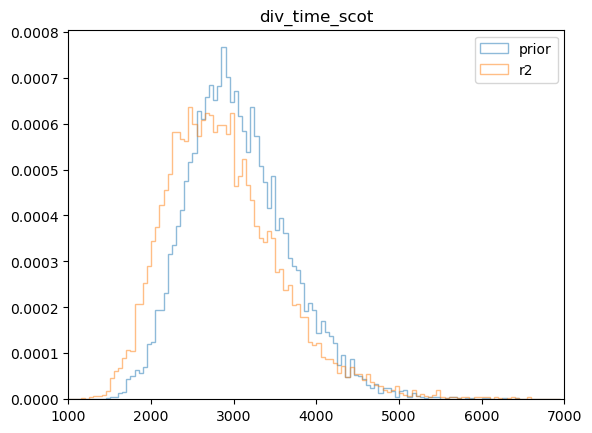

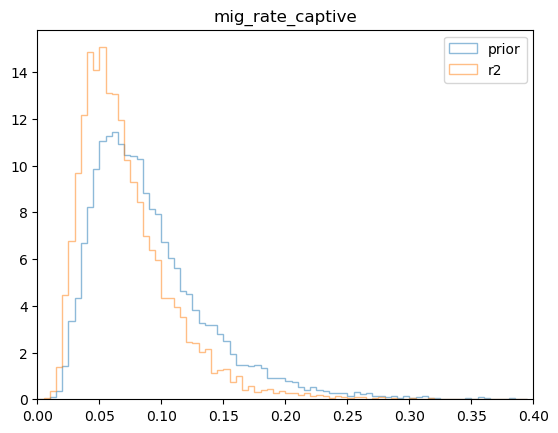

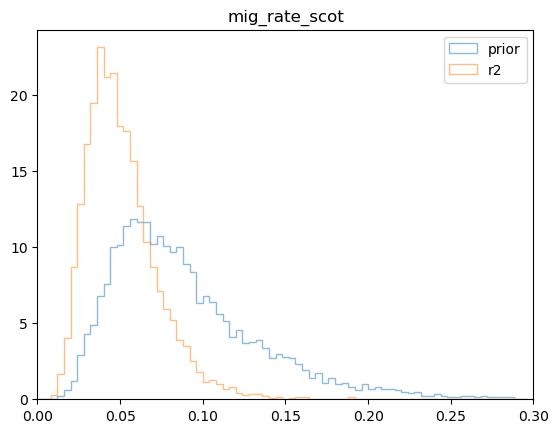

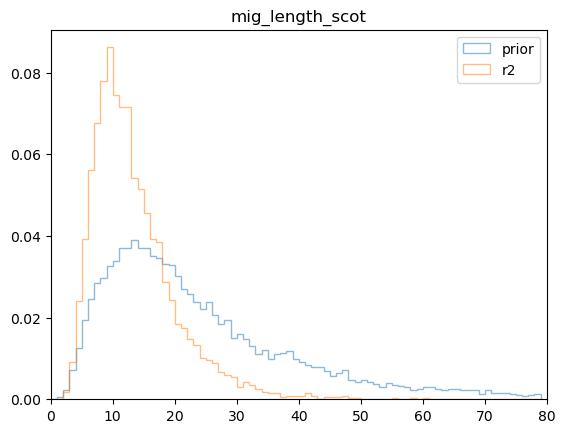

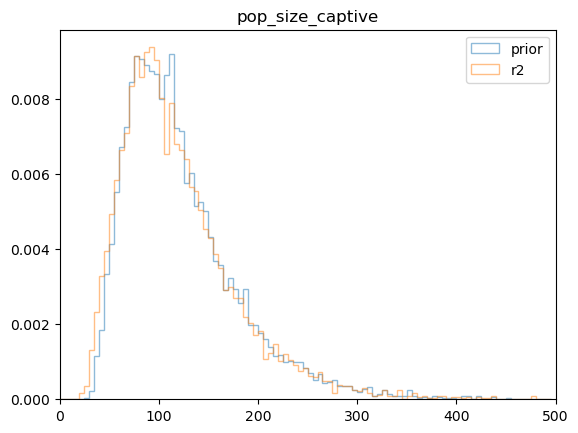

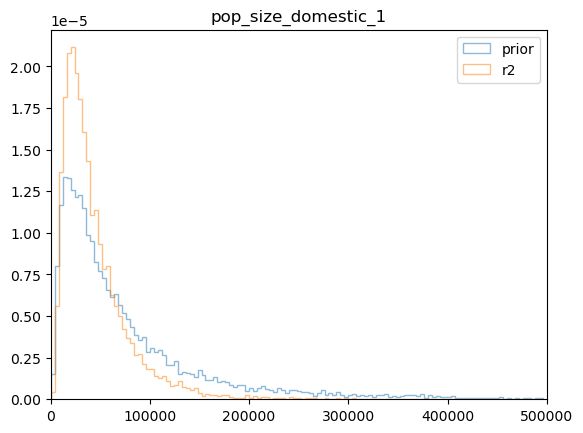

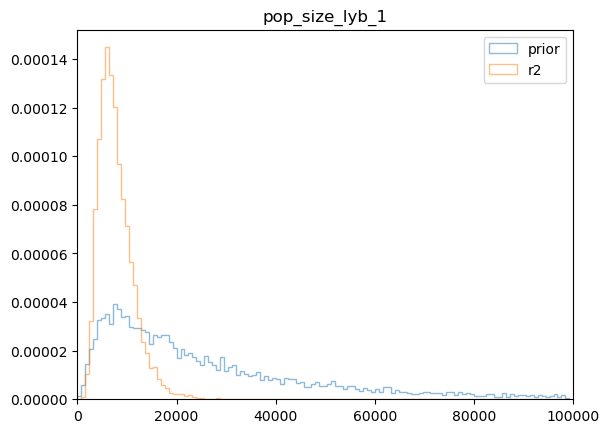

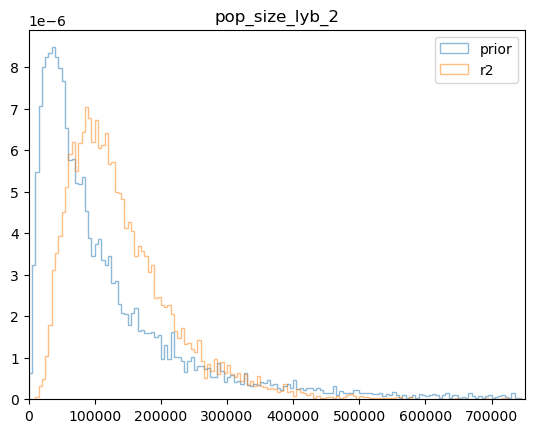

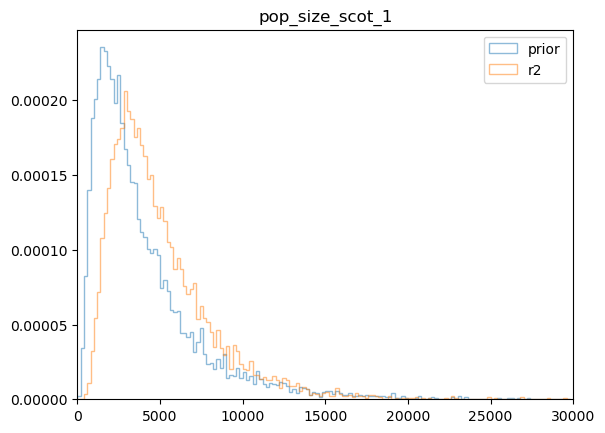

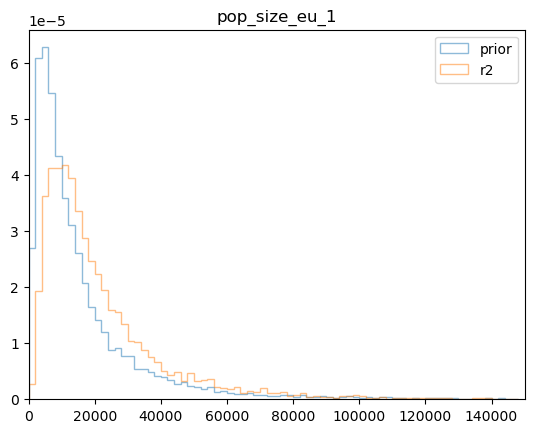

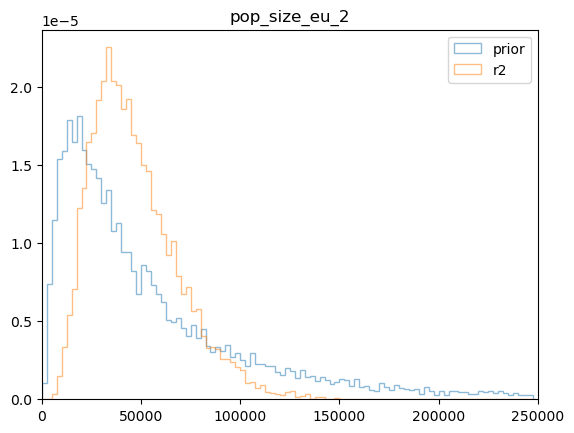

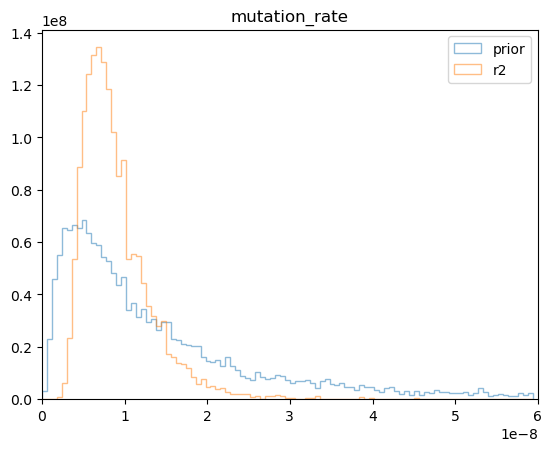

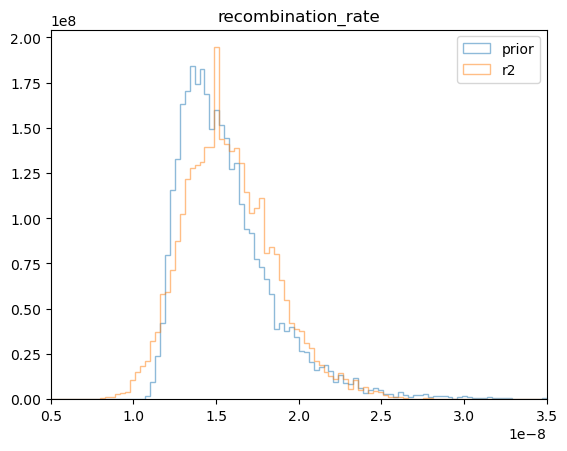

In [153]:
# plot parameter distributions
for num in range(0,16): 
    stat = names[num]
    
    plt.hist(theta[num][:],
             alpha=0.5,
             label='prior', bins=params[stat]["bins"], density=True, histtype='step')
    
    plt.hist(theta_2[:,num],
             alpha=0.5,
             label='r2', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_3[:,num],
        #     alpha=0.5,
         #    label='r3', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_4[:,num],
         #    alpha=0.5,
         #    label='r4', bins=params[stat]["bins"], density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(stat)
    #plt.yticks([])
    plt.xlim(params[stat]["lims"])
    plt.show()